# Monte Carlo Localisation

## Hintergrund

Die Monte Carlo Lokalisierung (MCL) ist ein probabilistischer Ansatz zur Schätzung der Pose (Position und Orientierung) eines Roboters in seiner Umgebung. Hier eine kurze Beschreibung:

- **Probabilistisches Framework**: MCL verwendet ein probabilistisches Framework, um die Position des Roboters zu schätzen. Es repräsentiert die Wahrscheinlichkeitsverteilung über möglichen Positionen des Roboters durch eine Menge von Partikeln (auch als Samples oder Partikel-Filter bezeichnet). Jeder Partikel stellt eine mögliche Pose des Roboters dar.

- **Stichprobenbasiertes Verfahren**: MCL verwendet eine stichprobenbasierte Methode, bei der Partikel zufällig aus dem Pose-Raum des Roboters gezogen werden. Diese Partikel werden dann anhand von Sensorinformationen aktualisiert, um die tatsächliche Pose des Roboters besser anzunähern.

- **Resampling**: Nach der Aktualisierung der Partikel werden sie entsprechend ihrer Gewichtungen neu abgetastet. Partikel mit höheren Gewichtungen haben eine größere Wahrscheinlichkeit, ausgewählt zu werden, während Partikel mit niedrigeren Gewichtungen mit geringerer Wahrscheinlichkeit ausgewählt werden. Dieser Resampling-Schritt konzentriert die Partikel auf Bereiche, die mit den Sensorinformationen besser übereinstimmen, und verbessert so die Genauigkeit der Lokalisierung.

- **Sensorfusion**: MCL integriert Daten aus verschiedenen Sensoren wie Odometrie, Laser-Entfernungsmesser oder Kameras, um die Pose des Roboters zu schätzen. Durch die Kombination von Informationen aus verschiedenen Sensoren reduziert MCL Unsicherheiten und verbessert die Genauigkeit der Lokalisierung, selbst in komplexen Umgebungen mit Hindernissen oder Unsicherheiten.

Insgesamt ist MCL eine leistungsstarke Methode zur Lokalisierung von Robotern, die in Echtzeit arbeitet und es Robotern ermöglicht, sich in dynamischen Umgebungen zuverlässig zu lokalisieren und zu navigieren.

## Aufgabe

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MonteCarloLocalization:
    def __init__(self, num_particles, map_):
        self.num_particles = num_particles
        self.new_particles = num_particles // 10
        self.map = map_
        self.world_size = map_.world_size
        self.particles, self.orientations, self.weights = self._init_particles(num_particles)

    def _init_particles(self, num_particles):
        particles = np.random.uniform(0, self.world_size, size=(num_particles, 2))
        weights = np.ones(num_particles) / num_particles
        orientations = np.random.uniform(0, 2 * np.pi, size=num_particles)
        return particles, orientations, weights

    def get_estimated_position(self):
        """
        returns the estimated position of the agent
        """
        return np.median(self.particles, axis=0)

    def move(self, motion):
        """
        :param motion: (step_size, angle) tuple
        """
        step_size, angle = motion
        self.orientations = self.orientations + angle
        self.orientations %= 2 * np.pi
        dx = step_size * np.cos(self.orientations)
        dy = step_size * np.sin(self.orientations)
        self.particles += np.column_stack((dx, dy))
        self.particles %= self.world_size

    def _particle_distance(self, particle, measurement):
        """
        :param particle: 1x2 array
        :param measurement: (num_landmarks, 2) array
        returns the distance between particle and landmarks
        """
        particle_measurement = self.map.sense(particle)
        return np.linalg.norm(particle_measurement - measurement)

    def _normalize(self, weights):
        return weights / np.sum(weights)

    def redistribute(self):
        """
        redistribute some particles to the unexplored areas
        """
        # delete the particles with the lowest weights
        indices = np.argsort(self.weights)
        self.particles = np.delete(self.particles, indices[:self.new_particles], axis=0)
        self.orientations = np.delete(self.orientations, indices[:self.new_particles])
        self.weights = np.delete(self.weights, indices[:self.new_particles])

        # find the unexplored areas
        new_particles, new_orientations, new_weights = self._init_particles(self.new_particles)
        self.particles = np.vstack((self.particles, new_particles))
        self.orientations = np.hstack((self.orientations, new_orientations))
        self.weights = np.hstack((self.weights, new_weights))

    def sense(self, measurement):
        for i in range(self.num_particles):
            particle = self.particles[i]
            distance = self._particle_distance(particle, measurement)
            self.weights[i] *= self._measurement_prob(distance)

        self.weights = self._normalize(self.weights)

    def resample(self):
        indices = np.random.choice(self.num_particles, size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def _measurement_prob(self, distance):
        # Simulate the sensor noise
        prob = 1.0 / (distance + 1e-6)  # Add a small epsilon to avoid division by zero
        return prob

    def localize(self, motion, measurement):
        self.move(motion)
        self.sense(measurement)
        self.resample()
        self.redistribute()


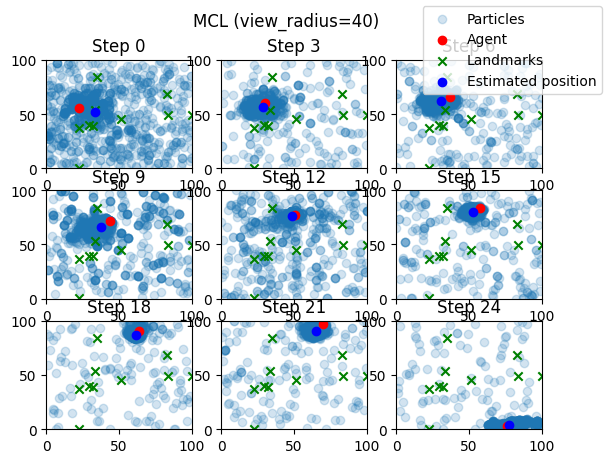

In [3]:
class Map:
    def __init__(self, world_size, view_radius, num_landmarks):
        self.world_size = world_size
        self.landmarks = self.generate_landmarks(num_landmarks)
        self.view_radius = view_radius

    def generate_landmarks(self, num_landmarks):
        return np.random.uniform(0, self.world_size, size=(num_landmarks, 2))

    def sense(self, true_position):
        """
        return the distances to the landmarks plus some noise
        """
        distances = np.linalg.norm(self.landmarks - true_position, axis=1)
        noised_distances = distances + np.random.normal(0, 2, size=len(distances))

        # set not viewable landmarks to infinity
        noised_distances[distances > self.view_radius] = self.world_size
        return noised_distances


class Agent:

    def __init__(self, world_size):
        self.pos = np.random.uniform(0, world_size, size=2)
        self.orientation = np.random.uniform(0, 2 * np.pi)
        self.world_size = world_size

    def move(self, step_size, angle):
        self.orientation += angle
        self.orientation %= 2 * np.pi
        self.pos += np.array([step_size * np.cos(self.orientation),
                             step_size * np.sin(self.orientation)])
        self.pos %= self.world_size

    def sense(self, map_):
        return map_.sense(self.pos)


def simulate(steps, map_, num_particles=1000):

    # Example usage:
    agent = Agent(map_.world_size)
    mc_localization = MonteCarloLocalization(num_particles, map_)

    for _ in range(steps):
        agent.move(3, 0.01)
        measurement = agent.sense(map_)
        mc_localization.localize((3, 0.01), measurement)
        estimated_position = mc_localization.get_estimated_position()
        yield agent.pos, mc_localization.particles, estimated_position

    print(f"Estimated position: {estimated_position}")
    print(f"True position: {agent.pos}")


def visualize():
    # simulation config
    view_radius = 40
    world_size = 100
    num_landmarks = 10
    steps = 30
    plot_every = steps // 9
    map_ = Map(world_size, view_radius, num_landmarks)

    # visualization
    fig, axs = plt.subplots(3, 3)

    ax_idx = 0
    for i, (pos, particles, estimated_position) in enumerate(simulate(steps, map_)):
        if i % plot_every != 0:
            continue

        if ax_idx >= 9:
            break

        ax = axs[ax_idx // 3, ax_idx % 3]
        ax.scatter(particles[:, 0], particles[:, 1], alpha=0.2)
        ax.scatter(pos[0], pos[1], c='r', marker='o')
        ax.scatter(map_.landmarks[:, 0], map_.landmarks[:, 1], c='g', marker='x')
        ax.scatter(estimated_position[0], estimated_position[1], c='b', marker='o')
        ax.set_title(f"Step {i}")
        ax.set_xlim(0, world_size)
        ax.set_ylim(0, world_size)

        ax_idx += 1

    fig.legend(['Particles', 'Agent', 'Landmarks', 'Estimated position'], loc='upper right')
    plt.suptitle(f"MCL (view_radius={view_radius})")
    plt.show()


if __name__ == "__main__":
    visualize()